In [0]:
!cat /proc/meminfo

In [0]:
!cat /proc/cpuinfo

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

In [0]:
#imports
import time
import requests
import numpy as np
import pandas as pd
from random import seed
from random import random
from sklearn import metrics

from scipy.stats import zscore
import datetime

import matplotlib.pyplot as plt
from keras.regularizers import l2
from keras.utils import plot_model
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model

# Load the log and eliminate nulls
no shuffling


In [0]:
#log will be preprocessed
df = pd.read_csv('/content/drive/My Drive/Student/VFU/s2/Process mining/logs/new/incident_event_log.csv',
                 na_values=['NA', '?'])

#1. get a list of all the columns 
columns = list(df) 

#2. show which columns have missing values
for column in columns: 
    if pd.isnull(df[column]).values.any():
        print(f'{column} has missing values')

#2.1. split the columns in two categories - droppable and non-droppable
droppable_na = ['opened_by','sys_created_by','sys_created_at','rfc','caused_by','closed_code','resolved_at']

#2.2. to the list of droppables we add those that we deem are not needed for the model
#we also drop incident number (not needed index)
droppable_all = ['number','opened_by','sys_created_by','sys_created_at','rfc','caused_by','closed_code',
                 'resolved_at','incident_state','active','sys_mod_count','opened_by','sys_updated_at',
                 'contact_type','knowledge','u_priority_confirmation','notify','resolved_at']
non_droppable_na = ['caller_id','location','category','subcategory','u_symptom','cmdb_ci','assignment_group',
                 'assigned_to','problem_id','vendor','resolved_by']

#3. For these columns, drop the ones we don't need, including columns that do not have NA values (2.2.)
print('------------------------------------')
print(f"Before drop: {list(df.columns)}")
df.drop(droppable_all, 1, inplace=True)
print('------------------------------------')
print(f"After drop: {list(df.columns)}")

#4. all non-droppable columns contain categorial values. Can't approximate, need to fill NA
for column in non_droppable_na:
  df[column].fillna(f'No {column}', inplace = True) # make sure to use the column name
print('------------------------------------')
#5 check for nulls again
columns = list(df)
for column in columns: 
    if pd.isnull(df[column]).values.any():
        print(f'{column} has missing values')
    else:
        print(f'{column} does not have missing values')

df.head()


# Continuous variables

## Calculate duration

In [0]:
df['opened_at'] = pd.to_datetime(df['opened_at'], format='%d/%m/%Y %H:%M')
df['closed_at'] = pd.to_datetime(df['closed_at'], format='%d/%m/%Y %H:%M')
df['case_duration'] = df['closed_at'] - df['opened_at']
df['case_duration'] = df['case_duration']/np.timedelta64(1,'D')
df.dtypes

In [0]:
df['case_duration']

## Standardization (case duration)

In [0]:
df['case_duration'] = zscore(df['case_duration']) 
# Calculate the z score of each value in the sample, relative to the sample mean and standard deviation.
# cases with average duration will be near zero, above zero is above average, and below zero is below average. 
# not needeed, can be left out
df.head()

## Encoding cyclical continuous feature (date)
opened at and closed at - Making the assumption that day of week is what is of interest to us. 

further reading: https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/

In [0]:
# 1. convert to date and extract weekday in text
df['opened_at'] = df['opened_at'].apply(lambda x: x.strftime('%w')).astype(int)
df['closed_at'] = df['closed_at'].apply(lambda x: x.strftime('%w')).astype(int)
#Weekday as a decimal number, where 0 is Sunday and 6 is Saturday.
df.head()

In [0]:
df.dtypes

## encode "made_sla"

In [0]:
# convert made_sla
df['made_sla'] = df['made_sla'].astype(int)
df.head()

### quantitative features analysis (data exploration)
plot distribution histo

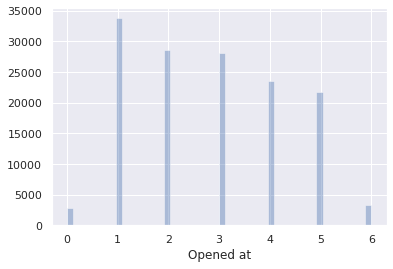

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

df['opened_at']=df['opened_at'].astype(int)
sns.set(style="darkgrid")
sns.distplot(df['opened_at'], kde=False, rug=False, axlabel='Opened at');

#### Fitting gamma distribution to case_duration


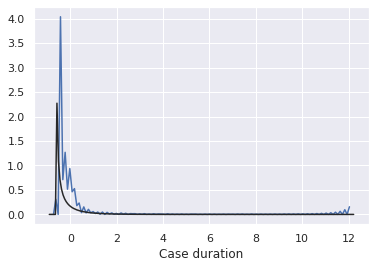

In [0]:
from scipy import stats

sns.distplot(df['case_duration'], hist=False, rug=False, kde=True, fit=stats.gamma, axlabel='Case duration');
#black line - gamm distribution
#blue line - variable values distribution

#### pairplot

In [0]:
sns.pairplot(df);

# Categorical variables

## One-hot encoding 

#### get list of categorical columns

In [0]:
dummies = {'caller_id':'','sys_updated_by':'','location':'','category':'','subcategory':'','u_symptom':'',
           'cmdb_ci':'','impact':'','urgency':'','priority':'','assignment_group':'','assigned_to':'',
           'problem_id':'','vendor':'','resolved_by':''}

# show unique values
for column in dummies:
  print(f'{column}: {len(list(df[column].unique()))} unique values')

#### dummy-encode

In [0]:
for column in dummies:
  dummies[column] = pd.get_dummies(df[column],prefix=column)
  df = pd.concat([df,dummies[column]],axis=1)
  df.drop(column, axis=1, inplace=True)

df.head() 
#result is 8011 columns: 8005 dummies + 6 continuous columns

### generate x and y - 20% split

In [0]:
target = ['case_duration']

X_train, y_train = df.iloc[:85024][df.columns.difference(target)], df.iloc[:85024][target]
X_val, y_val = df.iloc[85025:113366][df.columns.difference(target)], df.iloc[85025:113366][target]
X_test, y_test = df.iloc[113366:][df.columns.difference(target)], df.iloc[113366:][target]
X_test

### train model

In [0]:
start_time = time.time()

model = Sequential()
model.add(Dense(40, input_dim=X_train.shape[1], activation='relu',activity_regularizer=l2(0.001))) # Hidden 1
model.add(Dense(20, activation='linear', activity_regularizer=l2(0.001))) # Hidden 2
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error',
                       'mean_absolute_error'])

history = model.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs = 10,
                    batch_size = 512,
                    verbose = 2)

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 85024 samples, validate on 28341 samples
Epoch 1/10
85024/85024 - 25s - loss: 0.5548 - mean_squared_error: 0.5534 - mean_absolute_error: 0.3547 - val_loss: 0.6372 - val_mean_squared_error: 0.6360 - val_mean_absolute_error: 0.3982
Epoch 2/10
85024/85024 - 23s - loss: 0.2212 - mean_squared_error: 0.2200 - mean_absolute_error: 0.2418 - val_loss: 0.6650 - val_mean_squared_error: 0.6641 - val_mean_absolute_error: 0.4189
Epoch 3/10
85024/85024 - 23s - loss: 0.1104 - mean_squared_error: 0.1095 - mean_absolute_error: 0.1768 - val_loss: 0.7175 - val_mean_squared_error: 0.7168 - val_mean_absolute_error: 0.4484
Epoch 4/10
85024/85024 - 23s - loss: 0.0646 - mean_squared_error: 0.0638 - mean_absolute_error: 0.1383 - val_loss: 0.7439 - val_mean_squared_error: 0.7433 - val_mean_absolute_error: 0.4535
Epoch 5/10
85024/85024 - 23s - loss: 0.0460 - mean_squared_error: 0.0453 - mean_absolute_error: 0.1190 - val_loss

### evaluate model

In [0]:
results = model.evaluate(X_test, y_test, verbose=1)
print('test results:', results)

### plot metrics

In [0]:
#plot training metrics
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('One-hot Encoding Loss Curves')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss',
            'validation loss'],
            loc='upper right')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()

### network layout

In [0]:
from tensorflow.keras.utils import plot_model
import pydot_ng as pydot

plot_model(model,
           show_shapes=True,
           show_layer_names=True, 
           rankdir='TB')

In [0]:
model.summary()

## Target encoding

In [0]:
df.head()

In [0]:
encodable_columns = {'caller_id':'','sys_updated_by':'','location':'','category':'','subcategory':'','u_symptom':'',
           'cmdb_ci':'','impact':'','urgency':'','priority':'','assignment_group':'','assigned_to':'',
           'problem_id':'','vendor':'','resolved_by':''}

for column_name in encodable_columns:
  random_values = []
  for column_value in df[column_name].values:
    random_values.append(random()) 
  encodable_columns[column_name] = random_values
    #how to calculate randoms? -> https://machinelearningmastery.com/how-to-generate-random-numbers-in-python/
    #this is a new hyperparameter #we neeed a couple of runs, incl gaussian and sample
  s = pd.Series(encodable_columns[column_name], name = f'{column_name}_te')
  df = pd.concat([df,s],axis=1)
  df.drop(column_name, axis=1, inplace=True)

df.head()

In [0]:
# Source: https://maxhalford.github.io/blog/target-encoding-done-the-right-way/
def calc_smooth_mean(df1, df2, cat_name, target, weight):
    # Compute the global mean
    mean = df[target].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(cat_name)[target].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + weight * mean) / (counts + weight)

    # Replace each value by the according smoothed mean
    if df2 is None:
        return df1[cat_name].map(smooth)
    else:
        return df1[cat_name].map(smooth),df2[cat_name].map(smooth.to_dict())

In [0]:
WEIGHT = 5
#lower - more overfitting
#weights is a new hyperparameter It’s quite intuitive really: 
#you’re saying that you require that there must be at least 5 values for the sample mean to overtake the global mean. 
#itrt=0

encodable_columns = {'caller_id_te':'','sys_updated_by_te':'','location_te':'','category_te':'','subcategory_te':'',
                     'u_symptom_te':'','cmdb_ci_te':'','impact_te':'','urgency_te':'','priority_te':'',
                     'assignment_group_te':'','assigned_to_te':'','problem_id_te':'','vendor_te':'','resolved_by_te':''}

for column_name in encodable_columns:
  df[column_name] = calc_smooth_mean(df1=df, df2=None, cat_name=column_name, target='case_duration', weight=WEIGHT)

In [0]:
WEIGHT = 100
#lower - more overfitting
#weights is a new hyperparameter It’s quite intuitive really: 
#you’re saying that you require that there must be at least 5 values for the sample mean to overtake the global mean. 
#itrt=0

encodable_columns = {'caller_id':'','sys_updated_by':'','location':'','category':'','subcategory':'',
                     'u_symptom':'','cmdb_ci':'','impact':'','urgency':'','priority':'',
                     'assignment_group':'','assigned_to':'','problem_id':'','vendor':'','resolved_by':''}

for column_name in encodable_columns:
  df[column_name] = calc_smooth_mean(df1=df, df2=None, cat_name=column_name, target='case_duration', weight=WEIGHT)

In [0]:
df # it works

### generate x and y - 20% split


In [0]:
target = ['case_duration']

X_train, y_train = df.iloc[:85024][df.columns.difference(target)], df.iloc[:85024][target]
X_val, y_val = df.iloc[85025:113366][df.columns.difference(target)], df.iloc[85025:113366][target]
X_test, y_test = df.iloc[113366:][df.columns.difference(target)], df.iloc[113366:][target]
X_train

### train model

In [0]:
start_time = time.time()

model = Sequential()
model.add(Dense(20, input_dim=X_train.shape[1], activation='relu',activity_regularizer=l2(1e-3))) # Hidden 1
model.add(Dense(10, activation='linear', activity_regularizer=l2(1e-3))) # Hidden 2
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error',
                       'mean_absolute_error'])

history = model.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs = 10,
                    batch_size = 512,
                    verbose = 2)

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

### evaluate model

In [0]:
results = model.evaluate(X_test, y_test, verbose=1)
results
print('test loss, test acc:', results)

### plot metrics

In [0]:
#plot training metrics
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Target Encoding Loss Curves')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss',
            'validation loss'],
            loc='upper right')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()

In [0]:
plot_model(model, to_file='model.png',expand_nested=True,show_shapes=True)

### network layout

In [0]:
from tensorflow.keras.utils import plot_model
import pydot_ng as pydot

plot_model(model,
           show_shapes=True,
           show_layer_names=True, 
           rankdir='TB')

In [0]:
model.summary()

## Binary encoding
https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02

Two types of categorical variables: nominal and ordinal.
We can argue that all of our categorical variables are in fact nominal.

In [0]:
pip install category_encoders

In [0]:
import category_encoders as ce

df_ce = df.copy()

bec = ['caller_id','sys_updated_by','location','category','subcategory','u_symptom','cmdb_ci',
       'impact','urgency','priority','assignment_group','assigned_to', 'problem_id','vendor',
       'resolved_by']

encoder = ce.BinaryEncoder(cols=bec)
df_binary = encoder.fit_transform(df_ce)

df_binary.head() #works -> 122 columns, much less than dummy encoding

### generate x and y

In [0]:
target = ['case_duration']

X_train, y_train = df_binary.iloc[:85024][df_binary.columns.difference(target)], df_binary.iloc[:85024][target]
X_val, y_val = df_binary.iloc[85025:113366][df_binary.columns.difference(target)], df_binary.iloc[85025:113366][target]
X_test, y_test = df_binary.iloc[113366:][df_binary.columns.difference(target)], df_binary.iloc[113366:][target]
X_test

### train model

In [0]:
start_time = time.time()

model = Sequential()
model.add(Dense(20, input_dim=X_train.shape[1], activation='relu',activity_regularizer=l2(1e-3))) # Hidden 1
model.add(Dense(10, activation='linear', activity_regularizer=l2(1e-3))) # Hidden 2
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error',
                       'mean_absolute_error'])

history = model.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs = 100,
                    batch_size = 512,
                    verbose = 2)

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

### evaluate model

In [0]:
results = model.evaluate(X_test, y_test, verbose=1)
results
print('test loss, test acc:', results)

### plot metrics

In [0]:
#plot training metrics
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Binary Encoding Loss Curves')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss',
            'validation loss'],
            loc='upper right')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()

### network layout

In [0]:
from tensorflow.keras.utils import plot_model
import pydot_ng as pydot

plot_model(model,
           show_shapes=True,
           show_layer_names=True, 
           rankdir='TB')

In [0]:
model.summary()

#### feature encoding log scale

In [0]:
X = np.linspace(10, 100, 10)

plt.yscale('log')

plt.plot(X, np.log2(X), c = 'black', lw = 1., label = r'$F_C=\log_2(|C_{category}|)$')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

xi = 59
yi = np.log2(xi)
plt.scatter(xi,yi, color='red')

plt.legend()
plt.show()

##Hashing encoding  
https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159

https://alex.smola.org/papers/2009/Weinbergeretal09.pdf

In [0]:
pip install category_encoders

In [0]:
import category_encoders as ce

df_ce = df.copy()

hec = ['caller_id','sys_updated_by','location','category','subcategory','u_symptom','cmdb_ci',
       'impact','urgency','priority','assignment_group','assigned_to', 'problem_id','vendor',
       'resolved_by']

#encoder = ce.HashingEncoder(cols=hec, verbose=1, hash_method='sha256', n_components=15) 
df_hashing = ce.HashingEncoder.hashing_trick(df_ce,hashing_method='sha256', N=50, cols=hec, make_copy=False)

#uses MD5 by default
#n_components = 8 by defaults, set to 15 for all columns
#source code http://contrib.scikit-learn.org/categorical-encoding/_modules/category_encoders/hashing.html

In [0]:
df_hashing.shape

##### normalize

In [0]:
for i in range(0,15):
  df_hashing[f'col_{i}'] = zscore(df_hashing[f'col_{i}']) 
df_hashing.iloc[:5,:]
#normalizing the encoded values penalized the model

In [0]:
df_hashing.shape

### generate x and y

In [0]:
target = ['case_duration']

X_train, y_train = df_hashing.iloc[:85024][df_hashing.columns.difference(target)], df_hashing.iloc[:85024][target]
X_val, y_val = df_hashing.iloc[85025:113366][df_hashing.columns.difference(target)], df_hashing.iloc[85025:113366][target]
X_test, y_test = df_hashing.iloc[113366:][df_hashing.columns.difference(target)], df_hashing.iloc[113366:][target]
X_test

### train model

In [0]:
import time
import matplotlib.pyplot as plt
from keras.regularizers import l1,l2

start_time = time.time()

model = Sequential()
model.add(Dense(20, input_dim=X_train.shape[1], activation='relu',activity_regularizer=l2(1e-3))) # Hidden 1
model.add(Dense(10, activation='linear', activity_regularizer=l2(1e-3))) # Hidden 2
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error',
                       'mean_absolute_error'])

history = model.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs = 100,
                    batch_size = 512,
                    verbose = 2)

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

### evaluate model

In [0]:
results = model.evaluate(X_test, y_test, verbose=1)
results
print('test loss, test acc:', results)

### plot metrics

In [0]:
#plot training metrics
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Hashing Encoding Loss Curves')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss',
            'validation loss'],
            loc='upper right')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()

### network layout

In [0]:
from tensorflow.keras.utils import plot_model
import pydot_ng as pydot

plot_model(model,
           show_shapes=True,
           show_layer_names=True, 
           rankdir='TB')

In [0]:
model.summary()

## Entity embeddings

In [0]:
https://github.com/mmortazavi/EntityEmbedding-Working_Example/blob/master/EntityEmbedding.ipynb

https://github.com/mayanksatnalika/ipython/blob/master/embeddings%20project/cycle_sharing/entity_embeddings_regression.ipynb

https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

https://developers.google.com/machine-learning/crash-course/embeddings/video-lecture

https://medium.com/@davidheffernan_99410/an-introduction-to-using-categorical-embeddings-ee686ed7e7f9

https://towardsdatascience.com/deep-learning-structured-data-8d6a278f3088

https://github.com/entron/entity-embedding-rossmann/blob/master/plot_embeddings.ipynb

### feature cardinality

In [0]:
embed_cols=[i for i in df.select_dtypes(include=['object'])]

for i in embed_cols:
    print(i,df[i].nunique())

### Categorical Features To List Format

We have to convert data to list format to match the network structure.

The following function takes the list of categorical features, and prepare such lists for the NN input.

#### data split

In [0]:
categorical_features = ['caller_id','sys_updated_by','location','category','subcategory',
                        'u_symptom','cmdb_ci','impact','urgency','priority','assignment_group',
                        'assigned_to', 'problem_id','vendor','resolved_by']


target = ['case_duration']

X_train, y_train = df.iloc[:85024][df.columns.difference(['case_duration'])], df.iloc[:85024][target]
X_val, y_val = df.iloc[85025:113366][df.columns.difference(['case_duration'])], df.iloc[85025:113366][target]
X_test, y_test = df.iloc[113366:][df.columns.difference(['case_duration'])], df.iloc[113366:][target]
X_test

In [0]:
X_train.shape

(85024, 20)

In [0]:
embed_cols=[i for i in X_train.select_dtypes(include=['object'])]

#converting data to list format to match the network structure
def preproc(X_train, X_val, X_test):

    input_list_train = []
    input_list_val = []
    input_list_test = []
    
    #the cols to be embedded: rescaling to range [0, # values)
    for c in embed_cols:
        raw_vals = np.unique(X_train[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        input_list_train.append(X_train[c].map(val_map).values)
        input_list_val.append(X_val[c].map(val_map).fillna(0).values)
        input_list_test.append(X_test[c].map(val_map).fillna(0).values)
     
    #the rest of the columns
    other_cols = [c for c in X_train.columns if (not c in embed_cols)]
    input_list_train.append(X_train[other_cols].values)
    input_list_val.append(X_val[other_cols].values)
    input_list_test.append(X_test[other_cols].values)
    
    return input_list_train, input_list_val, input_list_test

### Embedding dimension (hyperparameter)

In [0]:
for categorical_var in X_train.select_dtypes(include=['object']):
    
    cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
  
    no_of_unique_cat  = X_train[categorical_var].nunique()
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
  
    print('Categorical Variable:', categorical_var,
        'Unique Categories:', no_of_unique_cat,
        'Embedding Size:', embedding_size)

In [0]:
for categorical_var in X_train.select_dtypes(include=['object']):
    
    input_name= 'Input_' + categorical_var.replace(" ", "")
    print(input_name)

In [0]:
input_models=[]
output_embeddings=[]
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

for categorical_var in X_train.select_dtypes(include=['object']):
    
    #Name of the categorical variable that will be used in the Keras Embedding layer
    cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
  
    # Define the embedding_size
    no_of_unique_cat  = X_train[categorical_var].nunique()
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 100))
  
    #One Embedding Layer for each categorical variable
    input_model = Input(shape=(1,))
    output_model = Embedding(no_of_unique_cat, embedding_size, name=cat_emb_name)(input_model)
    output_model = Reshape(target_shape=(embedding_size,))(output_model)    
  
    #Appending all the categorical inputs
    input_models.append(input_model)
  
    #Appending all the embeddings
    output_embeddings.append(output_model)
  
#Other non-categorical data columns (numerical). 
#I define single another network for the other columns and add them to our models list.
input_numeric = Input(shape=(len(X_train.select_dtypes(include=numerics).columns.tolist()),))
embedding_numeric = Dense(128)(input_numeric) 
input_models.append(input_numeric)
output_embeddings.append(embedding_numeric)

#At the end we concatenate altogther and add other Dense layers
output = Concatenate()(output_embeddings)
output = Dense(1000, kernel_initializer="uniform")(output)
output = Activation('relu')(output)
output= Dropout(0.4)(output)
output = Dense(512, kernel_initializer="uniform")(output)
output = Activation('relu')(output)
output= Dropout(0.3)(output)
output = Dense(1, activation='linear')(output)

model = Model(inputs=input_models, outputs=output)
model.compile(loss='mean_squared_error', optimizer='Adam',metrics=['mse','mae'])

### Network architecture

In [0]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [0]:
model.summary()

### Training

In [0]:
X_train_list,X_val_list,X_test_list = preproc(X_train, X_val, X_test)

In [0]:
X_train_list

In [0]:
start_time = time.time()

history  =  model.fit(X_train_list,y_train,validation_data=(X_val_list,y_val), epochs = 100, batch_size = 512, verbose = 2)

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

### evaluate model

In [0]:
results = model.evaluate(X_test_list, y_test, verbose=1)
results
print('test loss, test acc:', results)

### Metrics

In [0]:
#plot training metrics
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Entity Embedding Loss Curves')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss',
            'validation loss'],
            loc='upper right')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()

## Orthogonal polynomial coding

In [0]:
https://contrib.scikit-learn.org/categorical-encoding/polynomial.html

# final metrics

## overall loss values

#### define df

In [0]:
encoding = ['one-hot I','one-hot II','target I w=5','target II w-5','target I w-100','target II w-100',
'binary I','binary II','hashing I - default','hashing II - default','hashing III - default','hashing IV - default',
'hashing I - normalized','hashing II - normalized','hashing III - normalized','hashing IV - normalized',
'embeddings I - e-50','embeddings II - e-100','embeddings III - e-50','embeddings IV - e-100']
train_loss = [0.0177,0.0042,0.3865,0.2962,0.4363,0.3390,0.5168,0.2635,0.9817,0.8860,0.6940,0.4882,0.9985,
              0.9178,0.6920,0.4633,0.0356,0.0103,0.0334,0.0108,]
val_loss = [0.7949,0.8776,0.4237,0.4772,0.4520,0.4236,0.7240,0.9362,0.8485,0.8525,0.7553,0.8556,0.8753,
            0.8643,0.7426,0.8459,0.8856,0.9805,0.8171,0.8828]
test_loss = [1.0902,1.2711,0.5366,0.5618,0.6064,0.6708,0.7429,1.6971,0.7306,0.7331,0.7360,0.8511,0.7538,
            0.7419,0.7642,0.8517,1.1423,1.2280,1.0170,1.1383]

df_final = pd.DataFrame({'training loss': train_loss,
                         'validation loss': val_loss,
                         'test loss': test_loss},
                           index=encoding)

Text(0, 0.5, 'Encoding method')

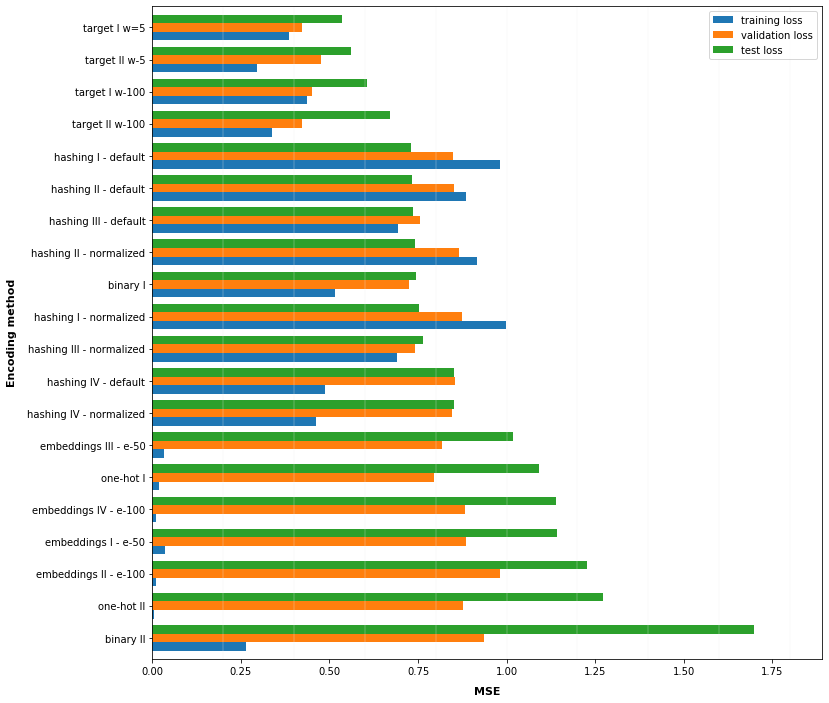

In [0]:
ax = df_final.sort_values(by=['test loss','training loss'],ascending=[False, False]).plot.barh(figsize=(12,12),
                                                                                               width=0.80)
#ax.tick_params(axis="both", which="both", bottom="on", top="off", labelbottom="on", left="off", right="off", labelleft="on")

vals = ax.get_xticks()
for tick in vals:
  ax.axvline(x=tick, linestyle='solid', alpha=0.2, color='#eeeeee', zorder=1)

ax.set_xlabel("MSE", labelpad=10, weight='bold', size=11)

ax.set_ylabel("Encoding method", labelpad=10, weight='bold', size=11)

## delta Gl

Text(0, 0.5, 'Encoding method')

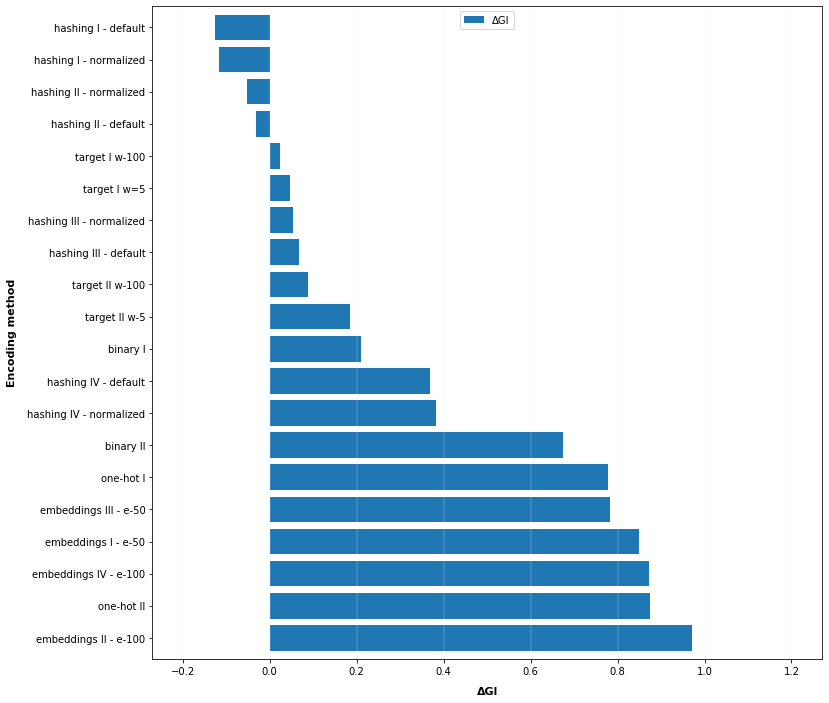

In [0]:
encoding = ['one-hot I','one-hot II','target I w=5','target II w-5','target I w-100','target II w-100',
'binary I','binary II','hashing I - default','hashing II - default','hashing III - default','hashing IV - default',
'hashing I - normalized','hashing II - normalized','hashing III - normalized','hashing IV - normalized',
'embeddings I - e-50','embeddings II - e-100','embeddings III - e-50','embeddings IV - e-100']

delta_Gl = [0.7777, 0.8741, 0.0464, 0.1839, 0.0225, 0.0874, 0.2096, 0.6739, -0.1268, -0.0315, 0.0663, 0.3685, -0.1165,
            -0.0516,0.0545, 0.3834, 0.8500, 0.9702, 0.7837, 0.8720]

df_Gl = pd.DataFrame({'ΔGl': delta_Gl},
                      index=encoding)

ax = df_Gl.sort_values(by=['ΔGl'],ascending=[False]).plot.barh(figsize=(12,12),width=0.80)

vals = ax.get_xticks()
for tick in vals:
  ax.axvline(x=tick, linestyle='solid', alpha=0.2, color='#eeeeee', zorder=1)

ax.set_xlabel("ΔGl", labelpad=10, weight='bold', size=11)

ax.set_ylabel("Encoding method", labelpad=10, weight='bold', size=11)